In [76]:
%pylab inline
import matplotlib.pyplot as plt
import PIL
import numpy as np
from glob import glob
from scipy.cluster.vq import kmeans
import networkx as nx
import math

Populating the interactive namespace from numpy and matplotlib


In [77]:
# изображение по сегментации
def apply_cut(img, classes, centers):
    assert len(centers) == 2
    result = img // 4
    result = img.copy()
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            result[x][y] += centers[classes[x][y]]
    result = np.clip(result, 0, 255)
    return result

In [78]:
# обработка изображения
def process_img(img_file, simple_cut_func, min_cut_func, centers, alpha, betta, show=False, show_penalty=False):
    img = np.array(PIL.Image.open(img_file))[:, :, :3].astype('int64')

    centers = np.array(centers)
    
    #жадная сегментация
    classes = simple_cut_func(img, centers)
    penalty = get_penalty(img, classes, centers, alpha, betta)
    clustered = apply_cut(img, classes, centers)
    
    #сегментация с минимальным разрезом
    mclasses = min_cut_func(img, centers, alpha, betta)
    mpenalty = get_penalty(img, mclasses, centers, alpha, betta)
    mclustered = apply_cut(img, mclasses, centers)
    
    # 
    if show:
        fig = plt.figure(figsize=(16, 8))
        fig.add_subplot(2, 2, 1)
        plt.imshow(img)

        fig.add_subplot(2, 2, 2)
        plt.imshow(clustered)
        
        fig.add_subplot(2, 2, 3)
        plt.imshow(mclustered)
        plt.show()
    
    if show_penalty:
        print(img_file)
        print('Penalty with simple_cut equals %f' % penalty)
        print('Penalty with min-cut equals %f' % mpenalty)

    return penalty

In [79]:
def simple_get_centers(img_file):
    img = np.array(PIL.Image.open(img_file))[:, :, :3].astype('float').reshape((-1, 3))
    return kmeans(img.astype('float'), 2)[0].astype('int64')

In [80]:
def get_penalty(img, classes, centers, alpha, betta):
    assert len(centers) == 2
    a, b = 0, 0
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            a += dist1(img[x][y], centers[classes[x][y]])
            if x + 1 < img.shape[0]:
                if classes[x][y] != classes[x + 1][y]:
                    b += dist2(img[x][y], img[x + 1][y])
            if y + 1 < img.shape[1]:
                if classes[x][y] != classes[x][y + 1]:
                    b += dist2(img[x][y], img[x][y + 1])
            
    return alpha * a + betta * b

In [81]:
def simple_cut(img, centers):
    assert len(centers) == 2
    classes = np.zeros_like(img[:, :, 0])
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if dist(img[x][y], centers[0]) < dist(img[x][y], centers[1]):
                classes[x][y] = 0
            else:
                classes[x][y] = 1
    return classes

In [82]:
# штраф 1 типа
def dist1(c1, c2):
    return math.sqrt(((c1 - c2) ** 2).sum())

# штраф 2 типа
def dist2(c1, c2):
    return 1.0 / (1.0 + dist1(c1, c2) / 255.0)

# номер пикселя по координатам
def node_id(i, j, n):
    return n * i + j

# координаты пикселя по номеру
def id_node(x, n):
    i = x // n
    j = x % n
    return i, j

def min_cut(img, centers, alpha, betta):
    #массив в котором к какому классу принадлежит пиксель
    classes = np.zeros_like(img[:, :, 0])
    
    #начинаем строить граф
    G = nx.DiGraph()
    n, m = img.shape[0], img.shape[1]
    
    #добавояем ребра
    for i in range(n):
        for j in range(m):
            #ребро вправо
            if i + 1 < n:
                G.add_edge(node_id(i, j, m), node_id(i + 1, j, m), capacity = betta * dist2(img[i][j], img[i + 1][j]))
            #ребро вниз
            if j + 1 < m:
                G.add_edge(node_id(i, j, m), node_id(i, j + 1, m), capacity = betta * dist2(img[i][j], img[i][j + 1]))
            #ребро вверх
            if i - 1 >= 0:
                G.add_edge(node_id(i, j, m), node_id(i - 1, j, m), capacity = betta * dist2(img[i][j], img[i - 1][j]))
            #ребро влево
            if j - 1 >= 0:
                G.add_edge(node_id(i, j, m), node_id(i, j - 1, m), capacity = betta * dist2(img[i][j], img[i][j - 1]))
            #ребра для штрафа 1-го типа
            G.add_edge(-1, node_id(i, j, m), capacity = alpha * dist1(img[i][j], centers[1]))
            G.add_edge(node_id(i, j, m), -2, capacity = alpha * dist1(img[i][j], centers[0]))
    
    #находим минимальный разрез
    min_cut_value, partition = nx.minimum_cut(G, -1, -2)
    
    for vertex in partition[0]:
        if vertex == -1:
            continue
        x, y = id_node(vertex, m)
        classes[x][y] = 0
    
    for vertex in partition[1]:
        if vertex == -2:
            continue
        x, y = id_node(vertex, m)
        classes[x][y] = 1
    
    return classes

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: numpy.hypot
  


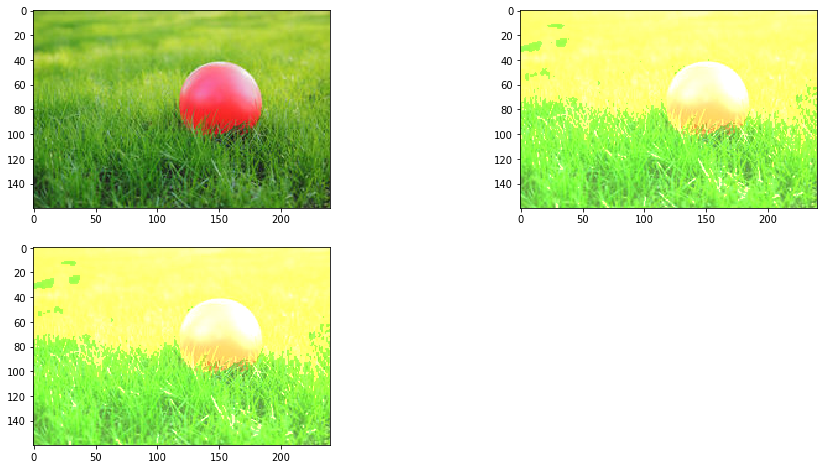

./imgs/ball.jpg
Penalty with simple_cut equals 3253000.117119
Penalty with min-cut equals 3249770.214763


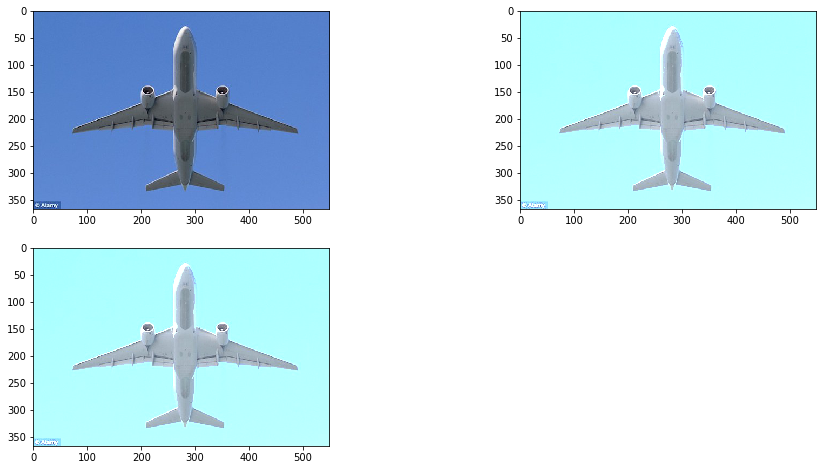

./imgs/plane.jpg
Penalty with simple_cut equals 4399269.640208
Penalty with min-cut equals 4398219.844324


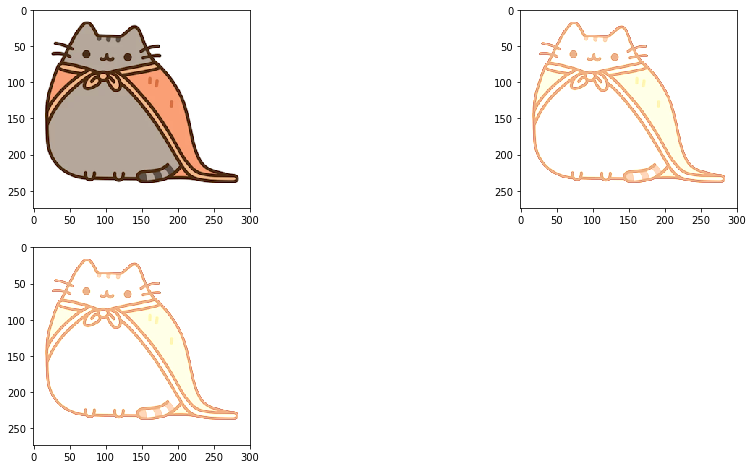

./imgs/cat.png
Penalty with simple_cut equals 6555182.994508
Penalty with min-cut equals 6555166.984203


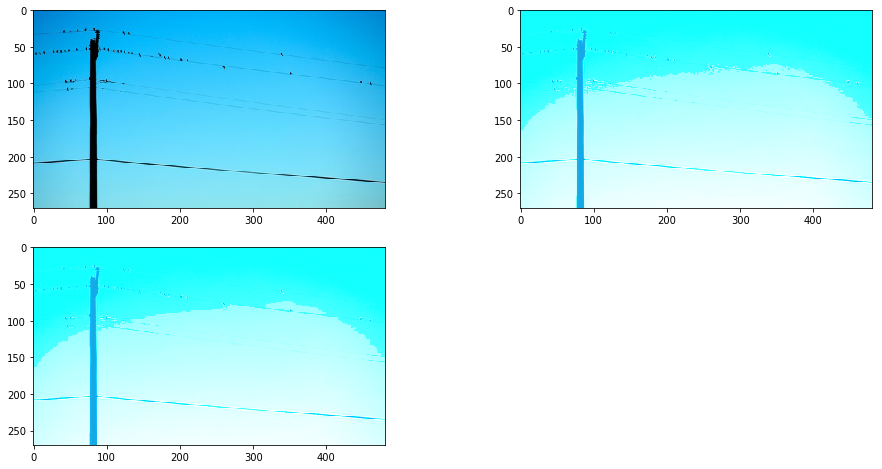

./imgs/sky.jpg
Penalty with simple_cut equals 8432057.601462
Penalty with min-cut equals 8427209.510706


In [73]:
alpha, betta = 2.0, 7.0

for img in glob('./imgs/*'):
    c = simple_get_centers(img)
    process_img(img, simple_cut, min_cut, c, alpha, betta, True, True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: numpy.hypot
  


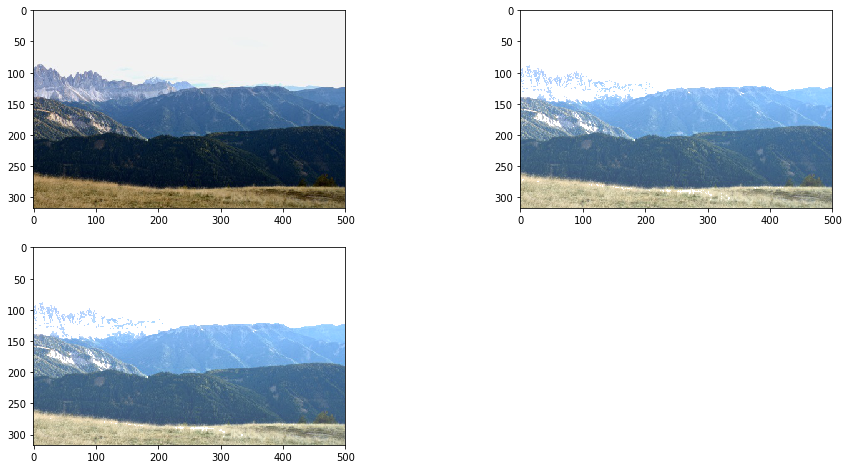

./imgs_multicolor/landscape.jpg
Penalty with simple_cut equals 17766756.354050
Penalty with min-cut equals 17762968.945835


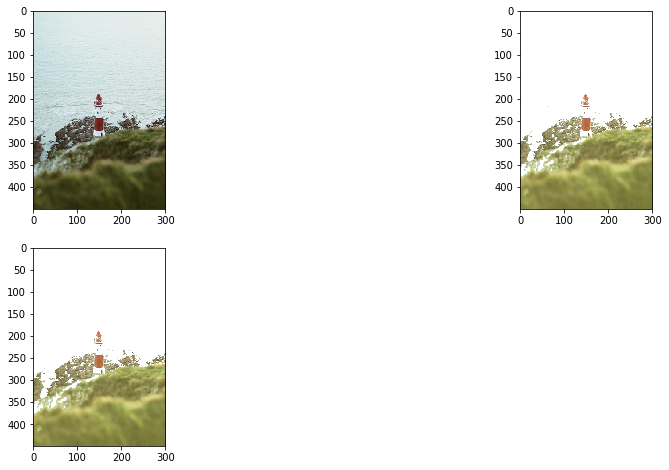

./imgs_multicolor/beacon.jpg
Penalty with simple_cut equals 7443011.023669
Penalty with min-cut equals 7442405.967160


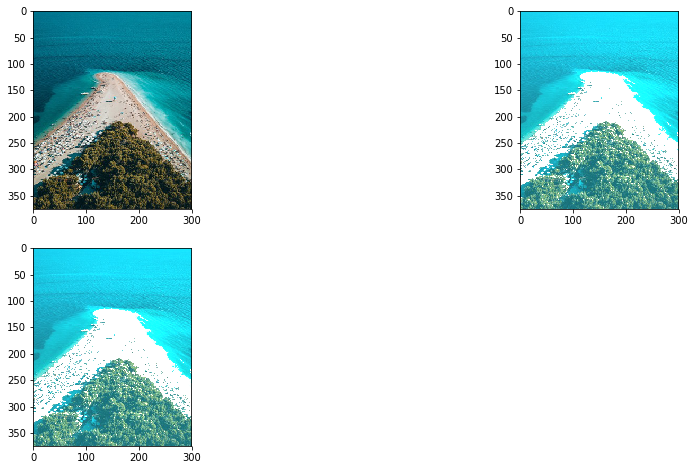

./imgs_multicolor/coast.jpg
Penalty with simple_cut equals 14268480.881468
Penalty with min-cut equals 14265394.062596


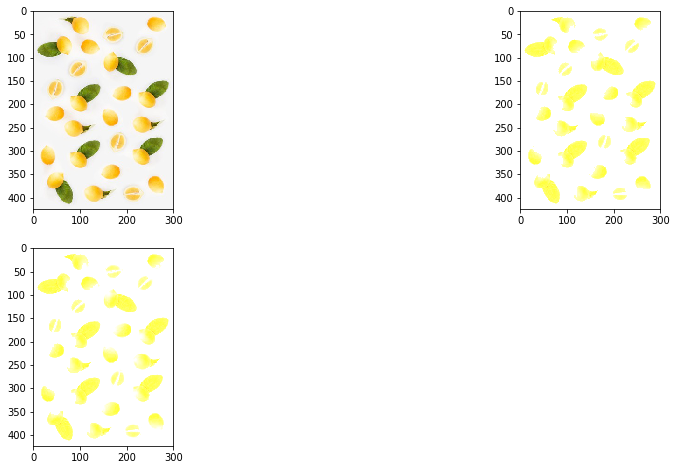

./imgs_multicolor/lemons.jpg
Penalty with simple_cut equals 7119454.683956
Penalty with min-cut equals 23753003.039140


In [83]:
for img in glob('./imgs_multicolor/*'):
    c = simple_get_centers(img)
    process_img(img, simple_cut, min_cut, c, alpha, betta, True, True)